## HYD 142 Final Project

Team B: Kenneth Larrieu, Catherine Truong, Charles Polc

### a. Plot the data sets, find their histograms, and find the first four moments and coefficient of variation

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
%matplotlib inline

df_az = pd.read_excel('data_project_19.xlsx', sheet_name='PARIA RIVER, AZ')
df_or = pd.read_excel('data_project_19.xlsx', sheet_name='JOHN DAY RIVER, OR')

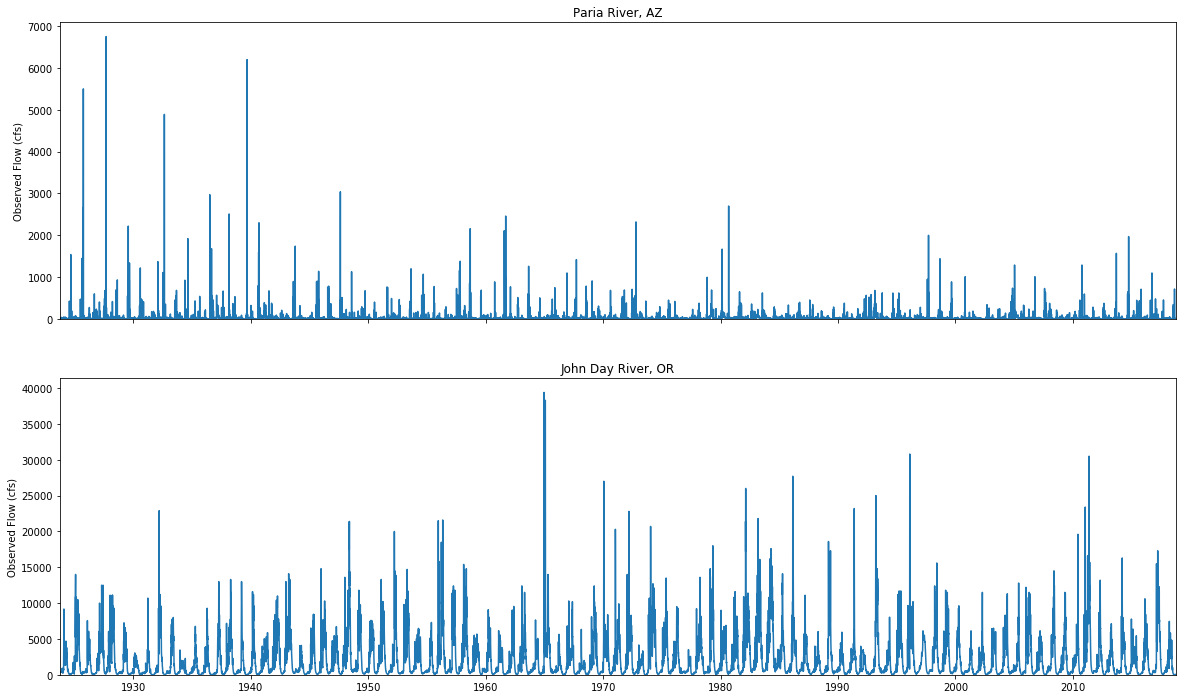

In [14]:
# plot the data sets
fig, ax = plt.subplots(2, 1, sharex=True, figsize=(20, 12))
ax[0].plot(df_az.DATE, df_az.Flow)
ax[0].set(title='Paria River, AZ')
ax[1].plot(df_or.DATE, df_or.Flow)
ax[1].set(title='John Day River, OR')
for axis in ax:
    axis.set(xlim=[df_az.DATE.tolist()[0], df_az.DATE.tolist()[-1]], ylabel='Observed Flow (cfs)')
    axis.set_ylim(bottom=0)
plt.show()

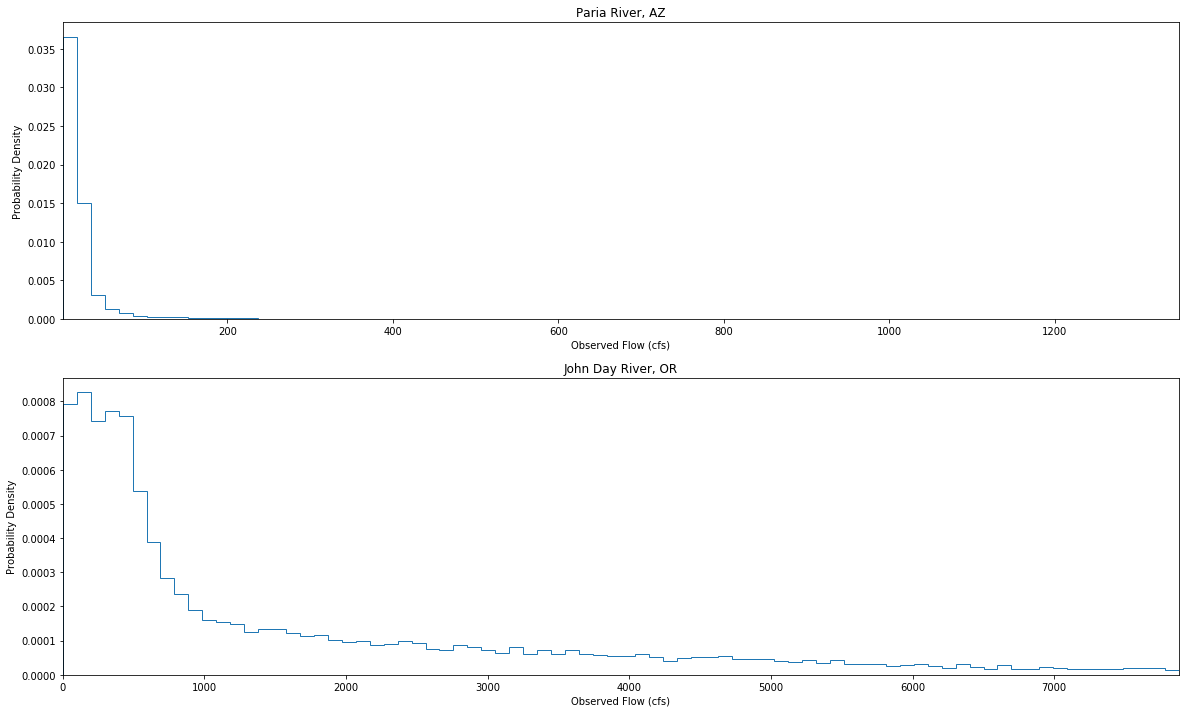

In [62]:
# histograms
fig, ax = plt.subplots(2, 1, figsize=(20, 12))
ax[0].hist(df_az.Flow, density=True, histtype='step', bins=400)
ax[0].set(title='Paria River, AZ',
          xlabel='Observed Flow (cfs)', ylabel='Probability Density',
          xlim=[min(df_az.Flow), 0.2*max(df_az.Flow)])
ax[1].hist(df_or.Flow, density=True, histtype='step', bins=400)
ax[1].set(title='John Day River, OR',
          xlabel='Observed Flow (cfs)', ylabel='Probability Density',
          xlim=[min(df_or.Flow), 0.2*max(df_or.Flow)])
plt.show()

In [63]:
# moments and CV
powers = np.arange(1, 5)
az_moments, or_moments = [[sum([q**p for q in df.Flow])/len(df) for p in powers] for df in [df_az, df_or]]
az_cv, or_cv = [np.std(df.Flow)/np.mean(df.Flow) for df in [df_az, df_or]]

a_df = pd.DataFrame([az_moments+[az_cv], or_moments+[or_cv]],
                    columns=['$$\mathbb{E}[X^%i]$$' % p for p in powers] +['$$CV$$'],
                   index=['Paria River, AZ', 'John Day River, OR'])
a_df

,$$\mathbb{E}[X^1]$$,$$\mathbb{E}[X^2]$$,$$\mathbb{E}[X^3]$$,$$\mathbb{E}[X^4]$$,$$CV$$
"Paria River, AZ",27.981293,1.276292e+04,3.627005e+07,1.707285e+11,3.911651
"John Day River, OR",2021.069110,1.152401e+07,1.077329e+11,1.472558e+15,1.349536


### b. Suggest two plausible models for such histograms, fitting them using the moments. Plot your results and comment on whether one of the models turns out to be better than the other.

Two plausible models would be ***(Exp, LP-III, Power Law?)***

[1, 2]

### c. Find the autocorrelation function of the records, extending your calculations to a lag equal to a tenth of the data length. Plot your results and comment on the relative decays on the data sets. What are the scales of the sets?

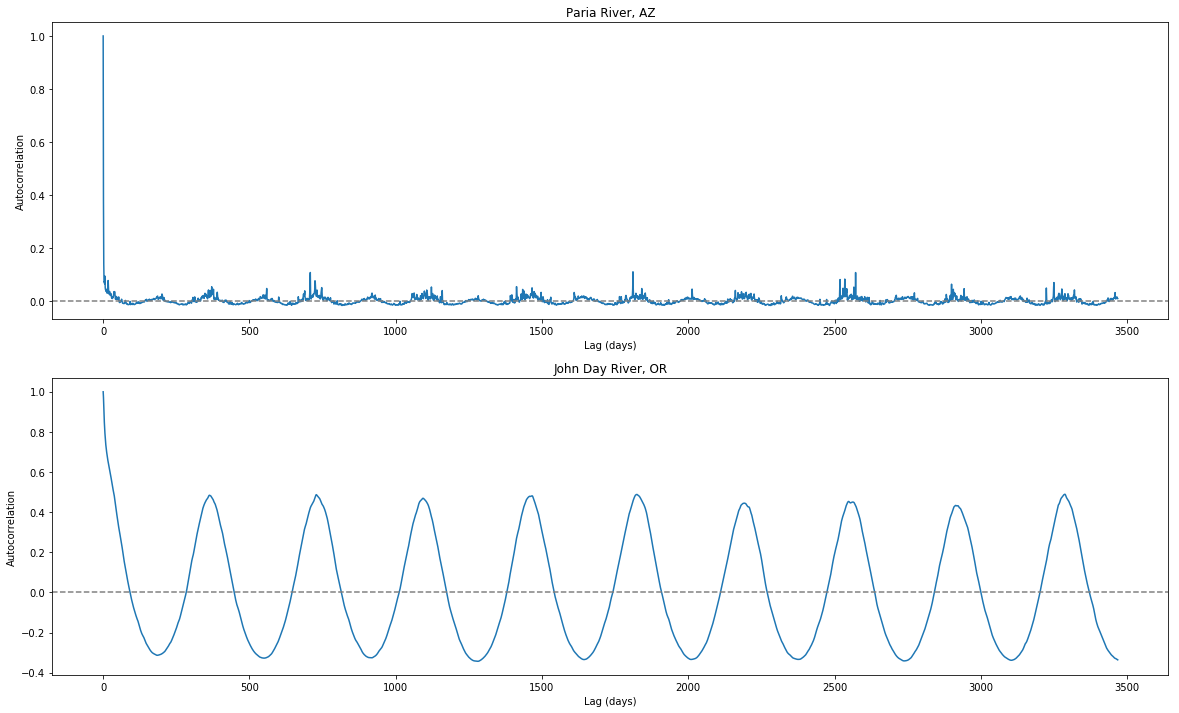

In [84]:
def acf(series, maxlags='default'):
    if maxlags == 'default':
        maxlags = len(series)//10
    lags = np.arange(maxlags)
    acorr = [1] + [np.corrcoef(series[:-lag], series[lag:])[0,1] for lag in lags[1:]]
    return lags, acorr

fig, ax = plt.subplots(2, 1, figsize=(20, 12))
ax[0].plot(*acf(df_az.Flow))
ax[0].set(title='Paria River, AZ')
ax[1].plot(*acf(df_or.Flow))
ax[1].set(title='John Day River, OR')
for axis in ax:
    axis.set(xlabel='Lag (days)', ylabel='Autocorrelation')
    axis.axhline(0, linestyle='--', color='gray')
plt.show()

The John Day River in Oregon decays much more slowly than the Paria River. Both exhibit annual oscillations indicative of periodicity. The John Day River oscillations have much higher amplitudes, indicative of the larger scale/longer memory of the system. This is expected since there is likely more gradual changes in the hydrograph due to a baseflow provided by groundwater and more temperate climate/regular precipitation patterns. In contrast, the Paria River is in an arid setting which exhibits much more flashy, temporally heterogeneous discharge patterns, so there is less correlation.

The scale of the Paria River streamflow is 55 days, while the scale of the John Day River streamflow is 92 days.

### Repeat parts a-c dividing each data set into two sets (the first andthe second halves) in order to test for stationarity, that is, in order to see if results already found are stable.

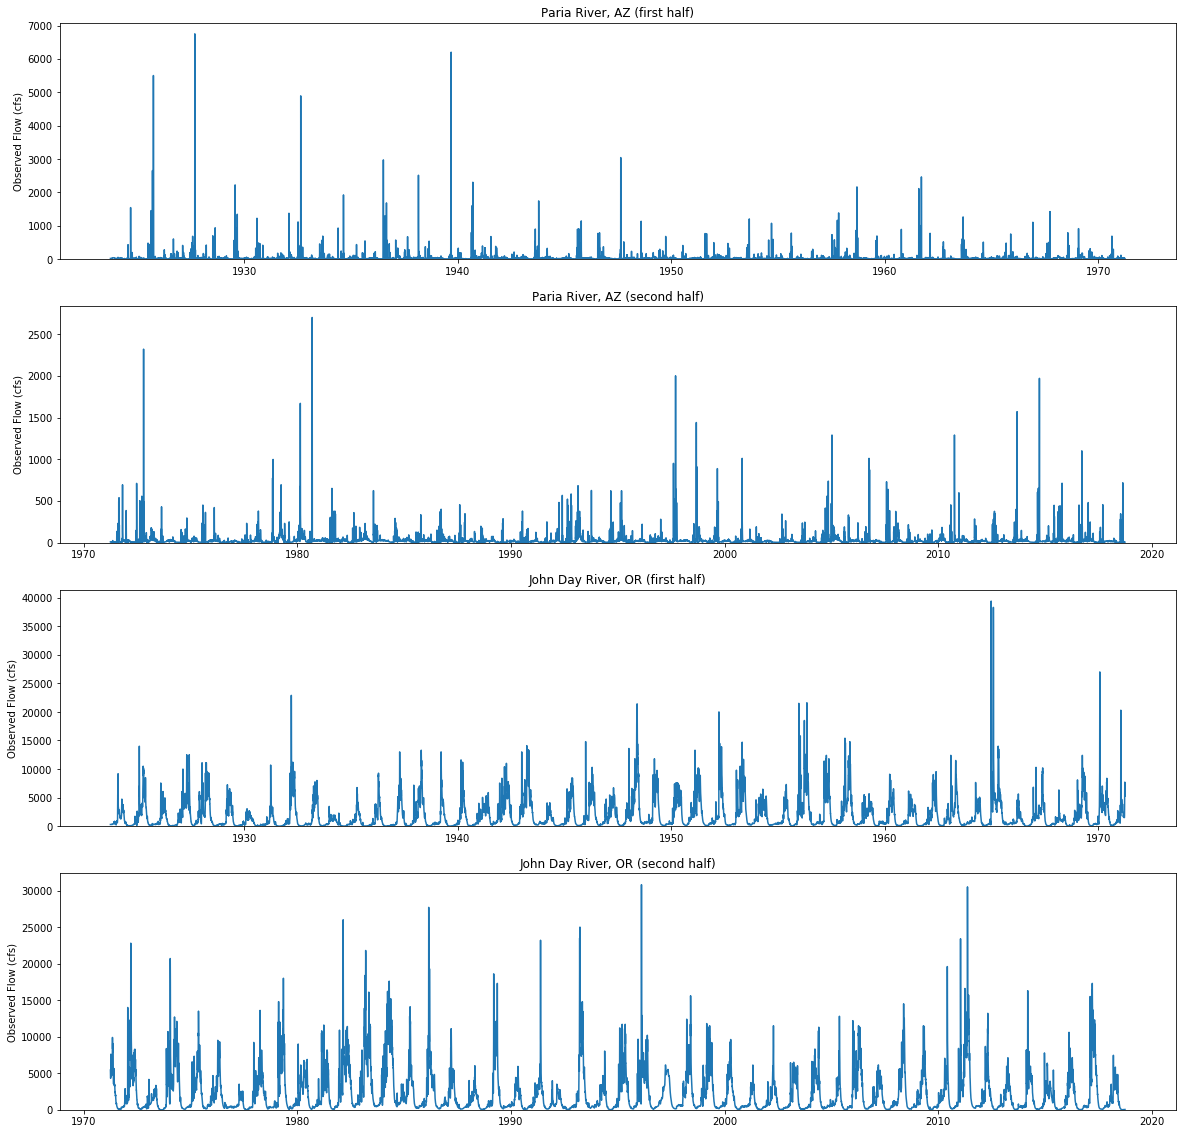

In [121]:
sdf_az = [df_az[:len(df_az)//2], df_az[len(df_az)//2:]]
sdf_or = [df_or[:len(df_or)//2], df_or[len(df_or)//2:]]

# plots
fig, ax = plt.subplots(4, 1, figsize=(20, 20))
ax[0].plot(sdf_az[0].DATE, sdf_az[0].Flow)
ax[0].set(title='Paria River, AZ (first half)')
ax[1].plot(sdf_az[1].DATE, sdf_az[1].Flow)
ax[1].set(title='Paria River, AZ (second half)')
ax[2].plot(sdf_or[0].DATE, sdf_or[0].Flow)
ax[2].set(title='John Day River, OR (first half)')
ax[3].plot(sdf_or[1].DATE, sdf_or[1].Flow)
ax[3].set(title='John Day River, OR (second half)')
for axis in ax:
    axis.set(ylabel='Observed Flow (cfs)')
    axis.set_ylim(bottom=0)
plt.show()

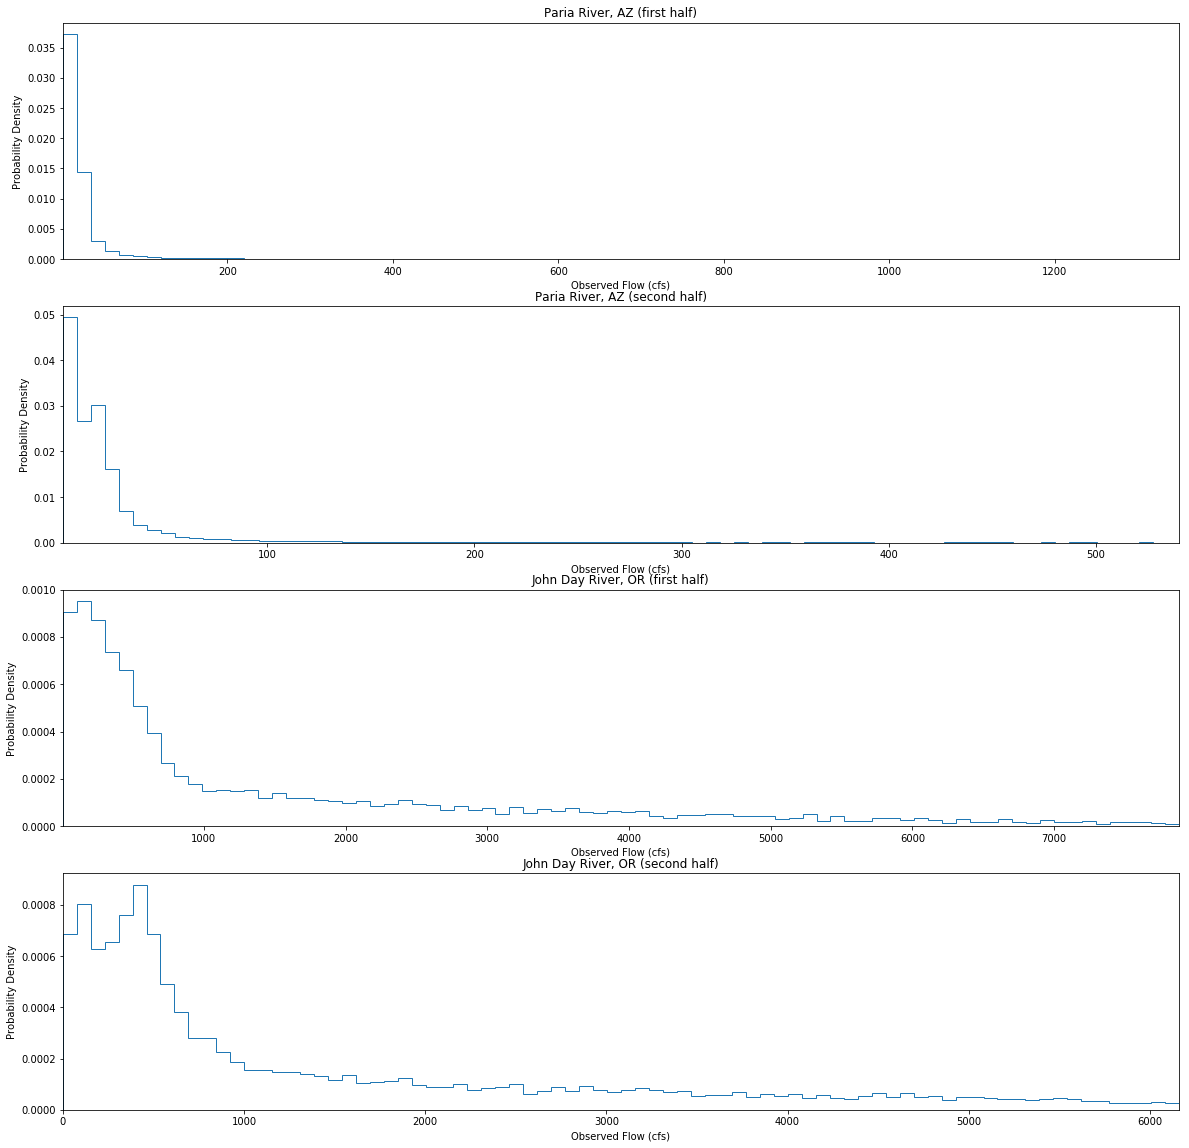

In [123]:
# histograms
fig, ax = plt.subplots(4, 1, figsize=(20, 20))
ax[0].hist(sdf_az[0].Flow, density=True, histtype='step', bins=400)
ax[0].set(title='Paria River, AZ (first half)',
          xlabel='Observed Flow (cfs)', ylabel='Probability Density',
          xlim=[min(sdf_az[0].Flow), 0.2*max(sdf_az[0].Flow)])
ax[1].hist(sdf_az[1].Flow, density=True, histtype='step', bins=400)
ax[1].set(title='Paria River, AZ (second half)',
          xlabel='Observed Flow (cfs)', ylabel='Probability Density',
          xlim=[min(sdf_az[1].Flow), 0.2*max(sdf_az[1].Flow)])
ax[2].hist(sdf_or[0].Flow, density=True, histtype='step', bins=400)
ax[2].set(title='John Day River, OR (first half)',
          xlabel='Observed Flow (cfs)', ylabel='Probability Density',
          xlim=[min(sdf_or[0].Flow), 0.2*max(sdf_or[0].Flow)])
ax[3].hist(sdf_or[1].Flow, density=True, histtype='step', bins=400)
ax[3].set(title='John Day River, OR (second half)',
          xlabel='Observed Flow (cfs)', ylabel='Probability Density',
          xlim=[min(sdf_or[1].Flow), 0.2*max(sdf_or[1].Flow)])
plt.show()

In [122]:
# moments and cv
powers = np.arange(1, 5)
az_moments1, az_moments2, or_moments1, or_moments2 = [[sum([q**p for q in df.Flow])/len(df) for p in powers] for df in [*sdf_az, *sdf_or]]
az_cv1, az_cv2, or_cv1, or_cv2 = [np.std(df.Flow)/np.mean(df.Flow) for df in [*sdf_az, *sdf_or]]

a_df = pd.DataFrame([az_moments1+[az_cv1], az_moments2+[az_cv2], or_moments1+[or_cv1], or_moments2+[or_cv2]],
                    columns=['$$\mathbb{E}[X^%i]$$' % p for p in powers] +['$$CV$$'],
                   index=['Paria River, AZ (first half)', 'Paria River, AZ (second half)',
                          'John Day River, OR (first half)', 'John Day River, OR (second half)'])
a_df

,$$\mathbb{E}[X^1]$$,$$\mathbb{E}[X^2]$$,$$\mathbb{E}[X^3]$$,$$\mathbb{E}[X^4]$$,$$CV$$
"Paria River, AZ (first half)",29.953087,1.964370e+04,6.605022e+07,3.296568e+11,4.571078
"Paria River, AZ (second half)",26.009613,5.882543e+03,6.491600e+06,1.180939e+10,2.774086
"John Day River, OR (first half)",1890.091631,1.025939e+07,9.497747e+10,1.395003e+15,1.368141
"John Day River, OR (second half)",2152.039041,1.278855e+07,1.204876e+11,1.550109e+15,1.327158


Comparing the moments and coefficient of variation, it appears that Paria River streamflows are nonstationary due to the significantly different magnitudes. In contrast, most John Day River values are within 10% of each other for the first and second halves, thus it might be approximated as a statioary process.

In [ ]:
# fitting to models


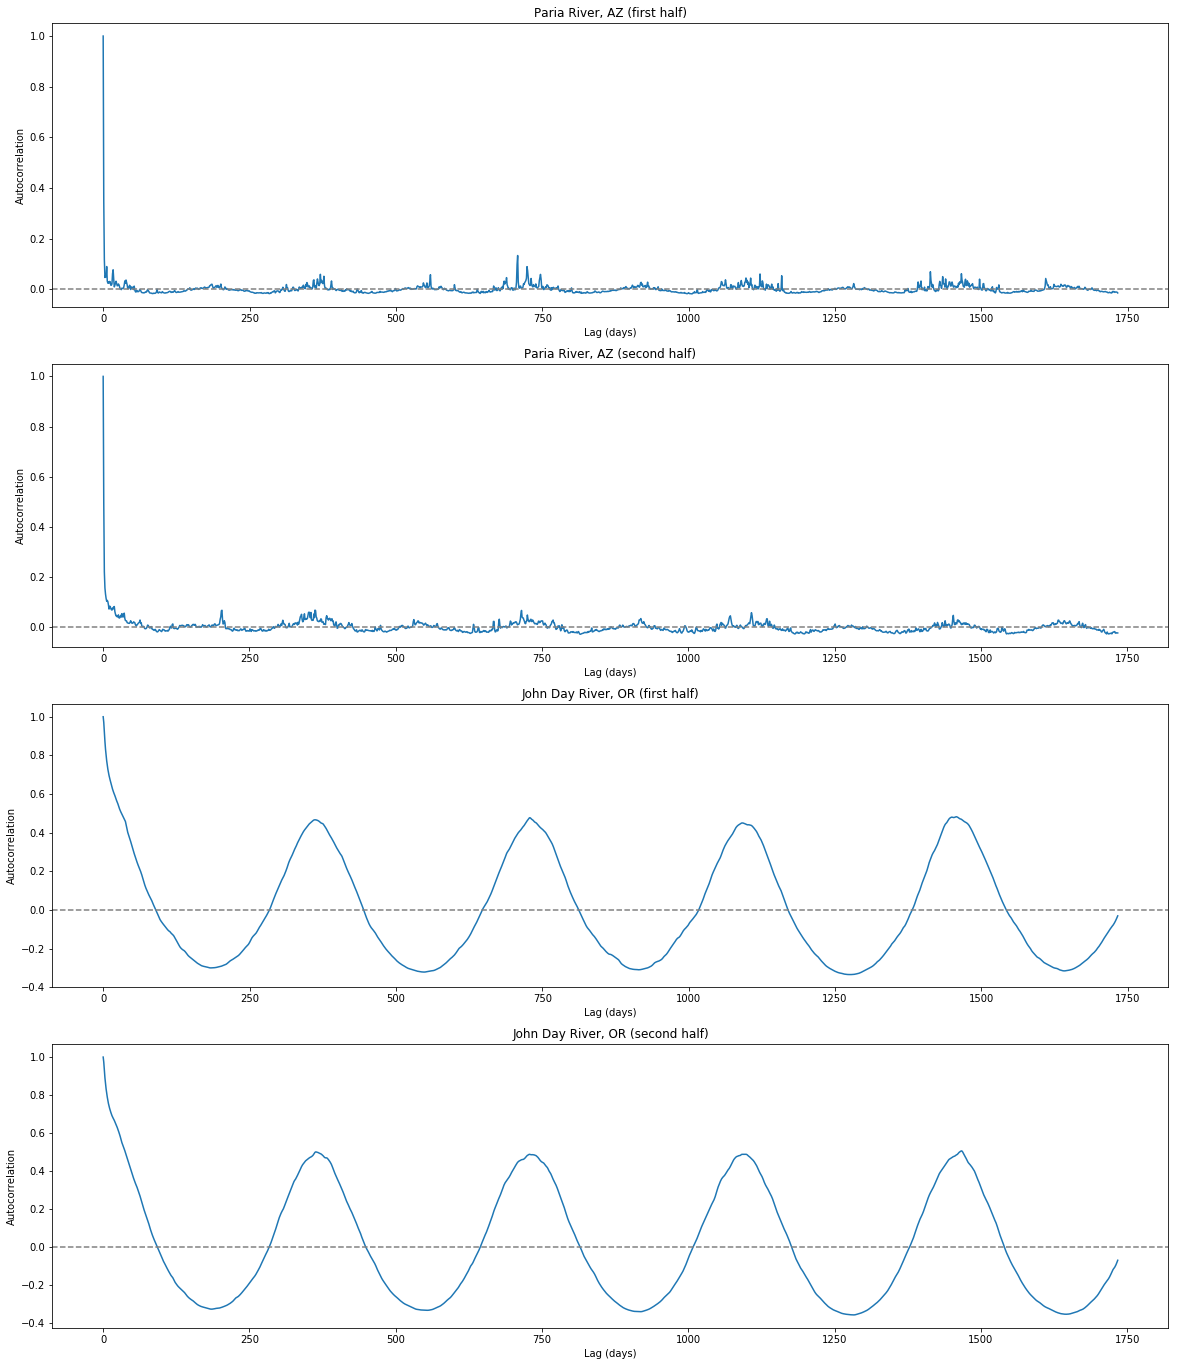

In [120]:
# autocorrelation and scale
fig, ax = plt.subplots(4, 1, figsize=(20, 24))
ax[0].plot(*acf(sdf_az[0].Flow))
ax[0].set(title='Paria River, AZ (first half)')
ax[1].plot(*acf(sdf_az[1].Flow))
ax[1].set(title='Paria River, AZ (second half)')
ax[2].plot(*acf(sdf_or[0].Flow))
ax[2].set(title='John Day River, OR (first half)')
ax[3].plot(*acf(sdf_or[1].Flow))
ax[3].set(title='John Day River, OR (second half)')
for axis in ax:
    axis.set(xlabel='Lag (days)', ylabel='Autocorrelation')
    axis.axhline(0, linestyle='--', color='gray')
plt.show()

Scale and stuff ***sasdfgeg***

### Now aggregate daily discharge data sets into monthly discharge data sets.

In [164]:
for df in [df_az, df_or]:
    df['month'] = [d.month for d in df['DATE']]
    df['year'] = [d.year for d in df['DATE']]

per = df_az.DATE.dt.to_period("M")
mdf_az = df_az.groupby(per).sum()
per = df_or.DATE.dt.to_period("M")
mdf_or = df_or.groupby(per).sum()

### g. Plot the new records, find their histograms, and also find the first four moments and coefficient of variation.

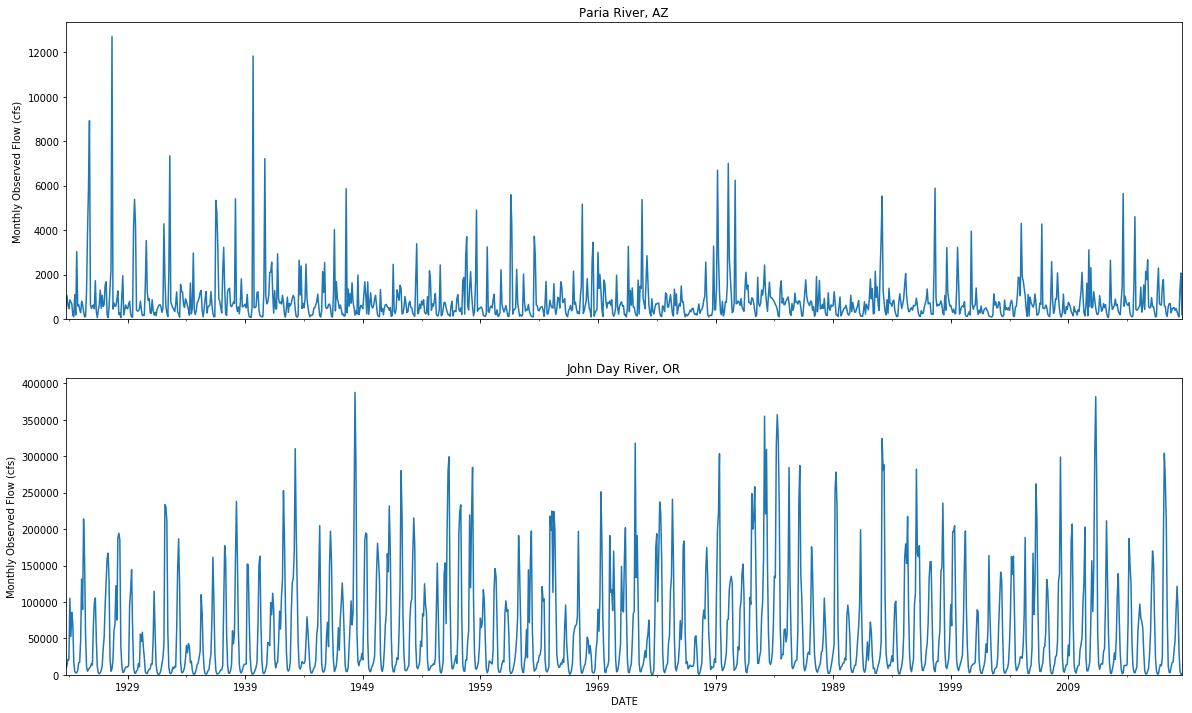

In [163]:
# plots
fig, ax = plt.subplots(2, 1, sharex=True, figsize=(20, 12))
mdf_az.Flow.plot(ax=ax[0])
ax[0].set(title='Paria River, AZ')
mdf_or.Flow.plot(ax=ax[1])
ax[1].set(title='John Day River, OR')
for axis in ax:
    axis.set(xlim=[mdf_az.index.tolist()[0], mdf_az.index.tolist()[-1]], ylabel='Monthly Observed Flow (cfs)')
    axis.set_ylim(bottom=0)
plt.show()

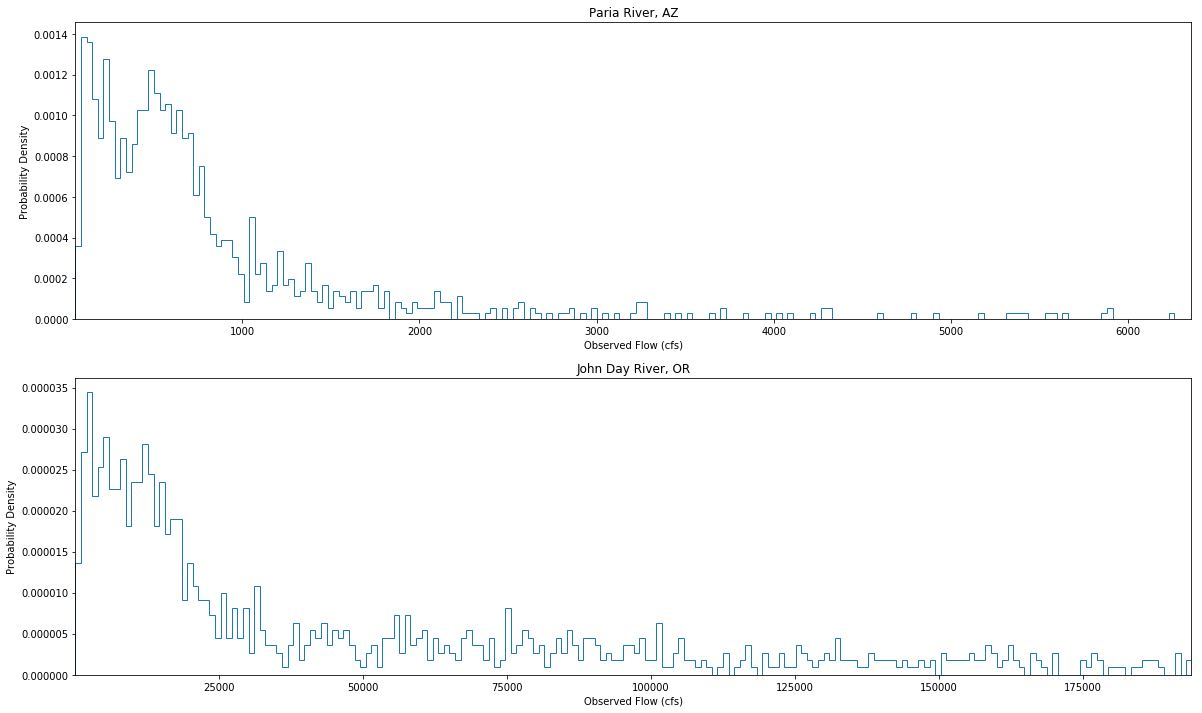

In [172]:
# histograms
fig, ax = plt.subplots(2, 1, figsize=(20, 12))
ax[0].hist(mdf_az.Flow, density=True, histtype='step', bins=400)
ax[0].set(title='Paria River, AZ',
          xlabel='Observed Flow (cfs)', ylabel='Probability Density',
          xlim=[min(mdf_az.Flow), 0.5*max(mdf_az.Flow)])
ax[1].hist(mdf_or.Flow, density=True, histtype='step', bins=400)
ax[1].set(title='John Day River, OR',
          xlabel='Observed Flow (cfs)', ylabel='Probability Density',
          xlim=[min(mdf_or.Flow), 0.5*max(mdf_or.Flow)])
plt.show()

In [165]:
# moments and CV
powers = np.arange(1, 5)
az_moments, or_moments = [[sum([q**p for q in df.Flow])/len(df) for p in powers] for df in [mdf_az, mdf_or]]
az_cv, or_cv = [np.std(df.Flow)/np.mean(df.Flow) for df in [mdf_az, mdf_or]]

a_df = pd.DataFrame([az_moments+[az_cv], or_moments+[or_cv]],
                    columns=['$$\mathbb{E}[X^%i]$$' % p for p in powers] +['$$CV$$'],
                   index=['Paria River, AZ', 'John Day River, OR'])
a_df

,$$\mathbb{E}[X^1]$$,$$\mathbb{E}[X^2]$$,$$\mathbb{E}[X^3]$$,$$\mathbb{E}[X^4]$$,$$CV$$
"Paria River, AZ",851.686737,1.905891e+06,9.470471e+09,7.269506e+13,1.275725
"John Day River, OR",61516.734263,8.940134e+09,1.781588e+15,4.188143e+20,1.167228


### h. Find the autocorrelation function of the new records, extending your calculations to a lag equal to a quarter of the data length. Plot your results and comment on the trends and relative decays on the two datasets.

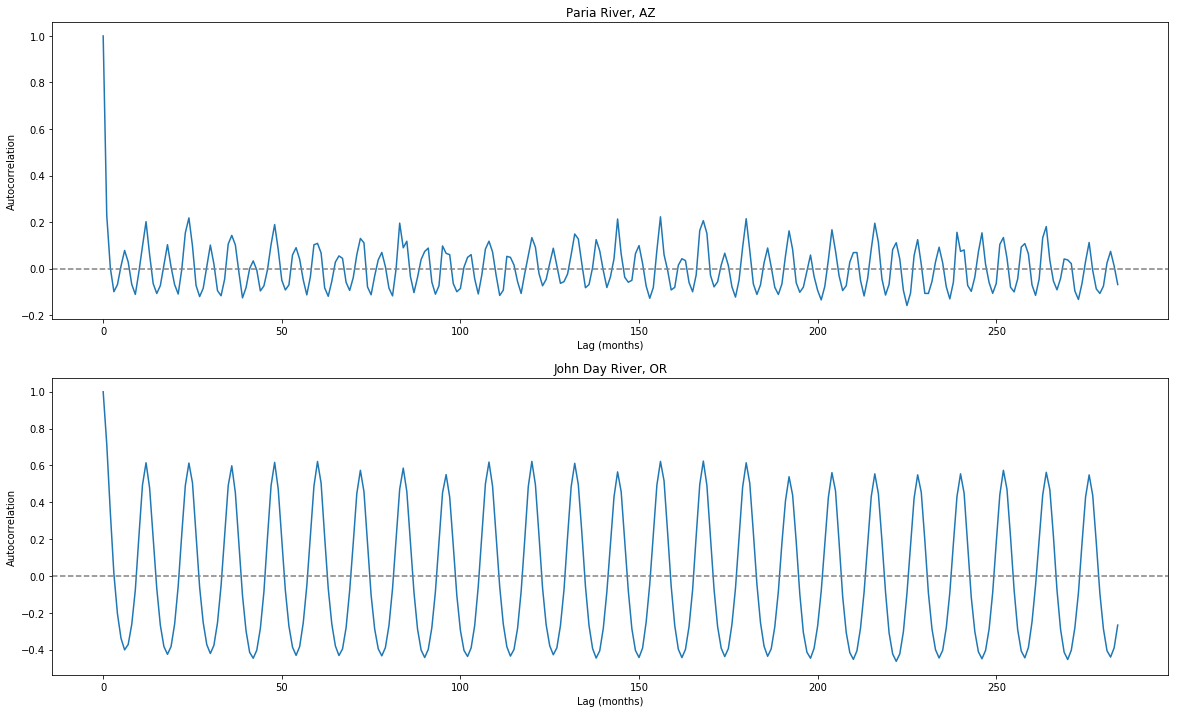

In [174]:
fig, ax = plt.subplots(2, 1, figsize=(20, 12))
ax[0].plot(*acf(mdf_az.Flow, maxlags=len(mdf_az.Flow)//4))
ax[0].set(title='Paria River, AZ')
ax[1].plot(*acf(mdf_or.Flow, maxlags=len(mdf_or.Flow)//4))
ax[1].set(title='John Day River, OR')
for axis in ax:
    axis.set(xlabel='Lag (months)', ylabel='Autocorrelation')
    axis.axhline(0, linestyle='--', color='gray')
plt.show()

Trends, decay, scale stuff ***sdfbsdb***

### Finally, aggregate all data sets to a yearly scale.

In [168]:
per = df_az.DATE.dt.to_period("Y")
ydf_az = df_az.groupby(per).sum()
per = df_or.DATE.dt.to_period("Y")
ydf_or = df_or.groupby(per).sum()

### k. Plot the new records, find their histograms, and also find the first four moments and coefficient of variation.

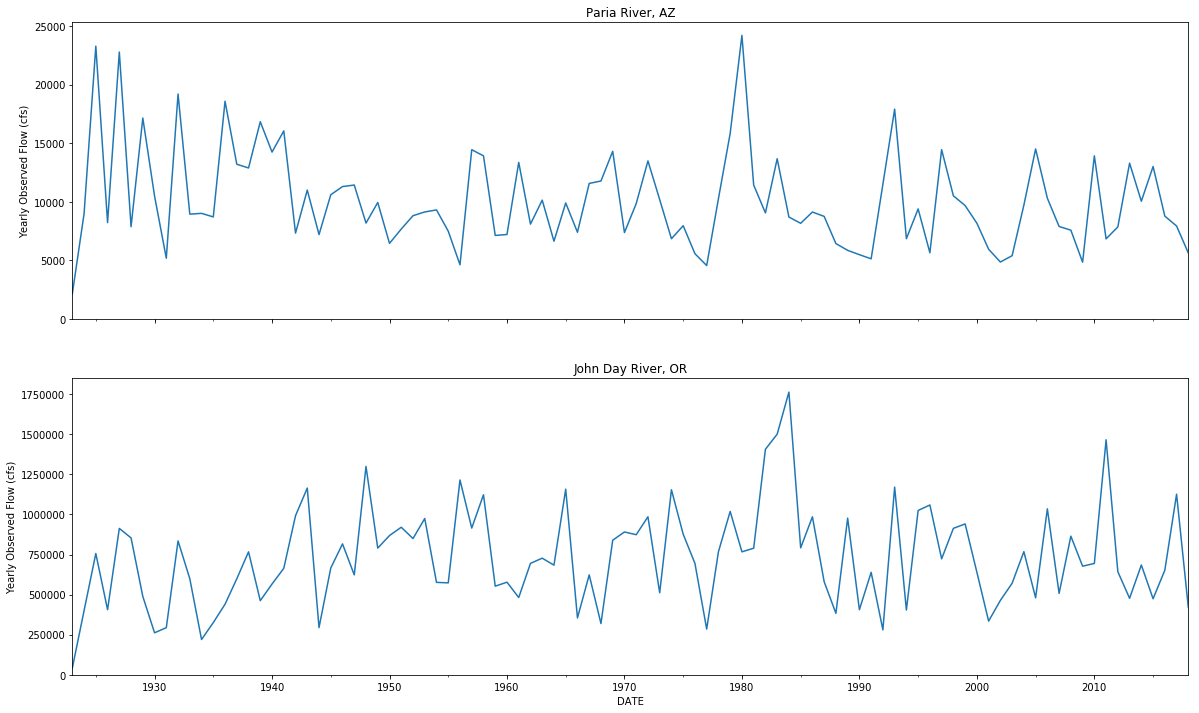

In [169]:
# plots
fig, ax = plt.subplots(2, 1, sharex=True, figsize=(20, 12))
ydf_az.Flow.plot(ax=ax[0])
ax[0].set(title='Paria River, AZ')
ydf_or.Flow.plot(ax=ax[1])
ax[1].set(title='John Day River, OR')
for axis in ax:
    axis.set(xlim=[ydf_az.index.tolist()[0], ydf_az.index.tolist()[-1]], ylabel='Yearly Observed Flow (cfs)')
    axis.set_ylim(bottom=0)
plt.show()

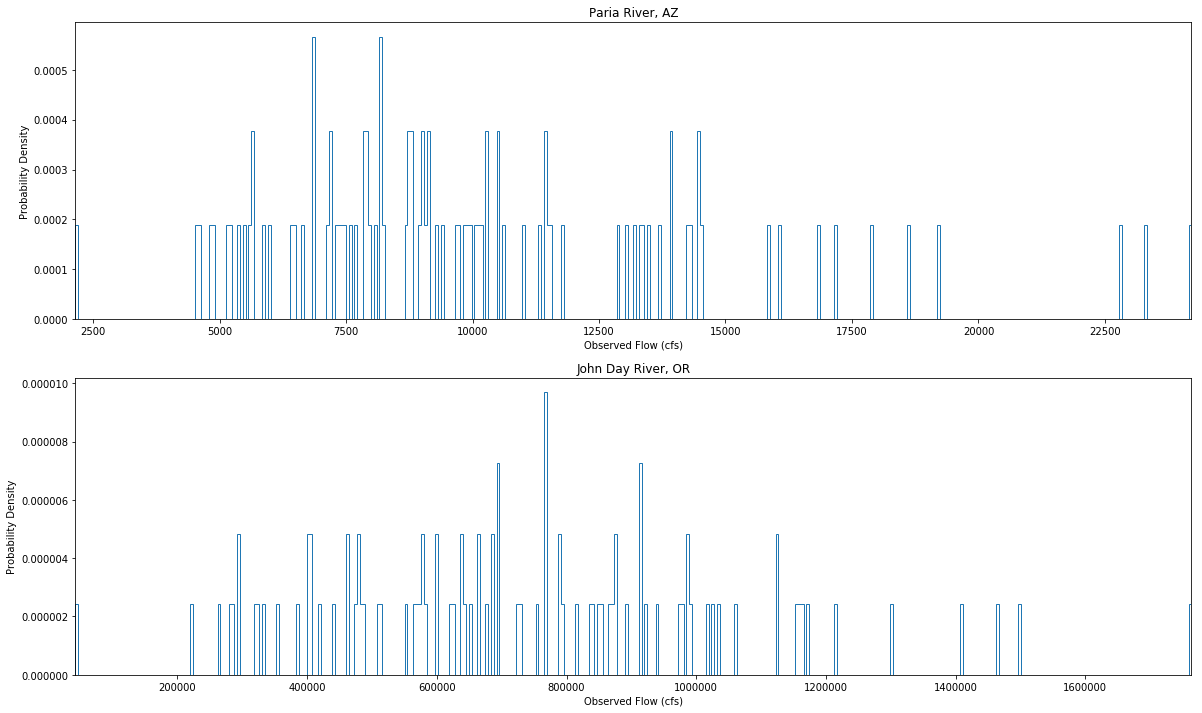

In [171]:
# histograms
fig, ax = plt.subplots(2, 1, figsize=(20, 12))
ax[0].hist(ydf_az.Flow, density=True, histtype='step', bins=400)
ax[0].set(title='Paria River, AZ',
          xlabel='Observed Flow (cfs)', ylabel='Probability Density',
          xlim=[min(ydf_az.Flow), max(ydf_az.Flow)])
ax[1].hist(ydf_or.Flow, density=True, histtype='step', bins=400)
ax[1].set(title='John Day River, OR',
          xlabel='Observed Flow (cfs)', ylabel='Probability Density',
          xlim=[min(ydf_or.Flow), max(ydf_or.Flow)])
plt.show()

In [173]:
# moments and CV
powers = np.arange(1, 5)
az_moments, or_moments = [[sum([q**p for q in df.Flow])/len(df) for p in powers] for df in [ydf_az, ydf_or]]
az_cv, or_cv = [np.std(df.Flow)/np.mean(df.Flow) for df in [ydf_az, ydf_or]]

a_df = pd.DataFrame([az_moments+[az_cv], or_moments+[or_cv]],
                    columns=['$$\mathbb{E}[X^%i]$$' % p for p in powers] +['$$CV$$'],
                   index=['Paria River, AZ', 'John Day River, OR'])
a_df

,$$\mathbb{E}[X^1]$$,$$\mathbb{E}[X^2]$$,$$\mathbb{E}[X^3]$$,$$\mathbb{E}[X^4]$$,$$CV$$
"Paria River, AZ",10113.780000,1.198214e+08,1.652009e+12,2.607573e+16,0.414012
"John Day River, OR",730511.219375,6.300818e+11,6.187933e+17,6.774759e+23,0.425100


### l. Find the autocorrelation function of the records, extending your calculations to a lag equal to a quarter of the data length. Plot your results and comment on the trends and relative decays on the two data sets.

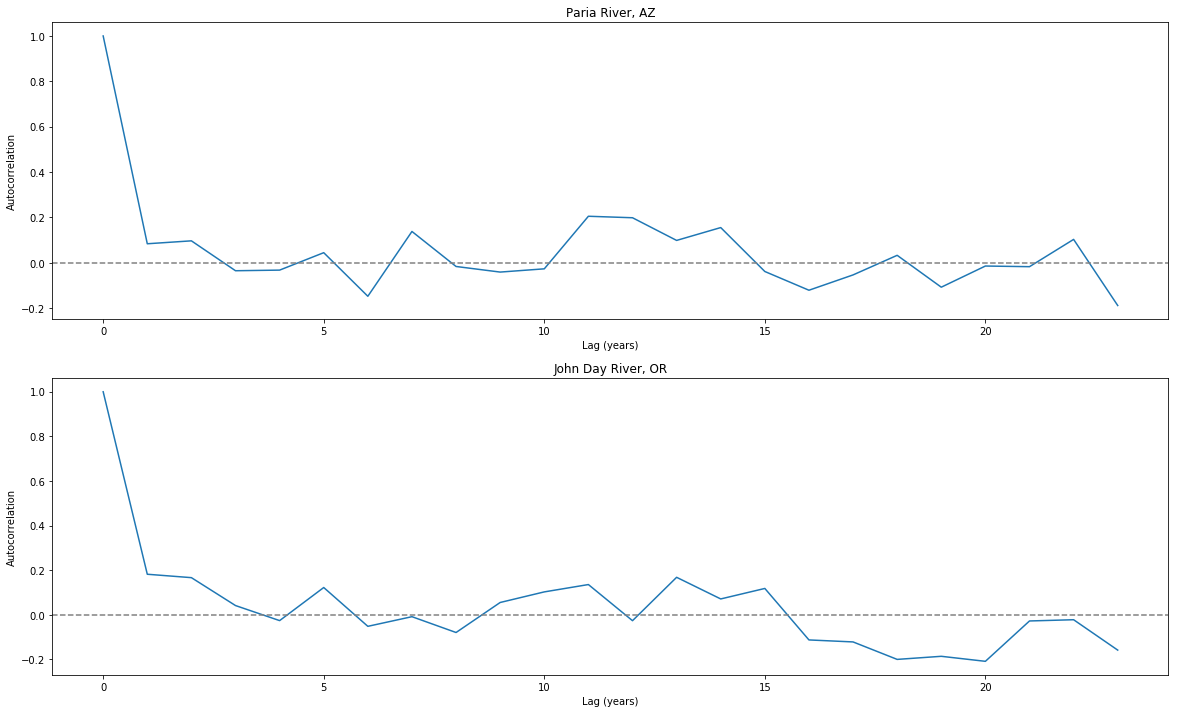

In [175]:
fig, ax = plt.subplots(2, 1, figsize=(20, 12))
ax[0].plot(*acf(ydf_az.Flow, maxlags=len(ydf_az.Flow)//4))
ax[0].set(title='Paria River, AZ')
ax[1].plot(*acf(ydf_or.Flow, maxlags=len(ydf_or.Flow)//4))
ax[1].set(title='John Day River, OR')
for axis in ax:
    axis.set(xlabel='Lag (years)', ylabel='Autocorrelation')
    axis.axhline(0, linestyle='--', color='gray')
plt.show()

Scale, decay, trends ***Sdbsdgb***

### m. Is the decay in autocorrelations consistent with simple time series models? Try AR(1), AR(2) and ARMA(1,1). Compute the power spectrum for the records. Is such consistent with power-law fractal noises?

### n. Find the rescaled range of the records and estimate their Hurst exponent. Is such related to the roughness seen on the records? Comment on the drought lengths associated with the diagrams. How unlikely are such conditions?

In [ ]:
# accumulated flows

# fit to line

# get residuals

# max - min residual for [:n] = range(n)

# plot in log-log, fit to get slope = hurst exponent

### o. Find the mass exponents for the data sets and asses whether the records may be represented as a multifractal.